In [43]:
import pandas            as pd
import missingno         as msno
import seaborn           as sns
import matplotlib.pyplot as plt

# Data Cleaning

In [2]:
# Import dataset into Pandas DataFrame
df_raw    = pd.read_csv("../dat/ship_data.csv")
n_records = df_raw.shape[0]

# Check column names and data types
print(df_raw.shape)
df_raw.info()

(16248, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 26 columns):
Time                                                          16248 non-null int64
Main Engine Fuel Consumption (MT/day)                         16085 non-null float64
Main Engine Using HFO (bool)                                  16085 non-null float64
Main Engine Using MGO (bool)                                  16085 non-null float64
Draft Forward (meters)                                        16085 non-null float64
Draft Aft (meters)                                            16085 non-null float64
Draft Mid-1 (meters)                                          16085 non-null float64
Draft Mid-2 (meters)                                          16085 non-null float64
Shaft Speed (RPM)                                             16085 non-null float64
Shaft Torque (kNm)                                            16085 non-null float64
Shaft Power (kW)               

### Missing Records

Time                                                            0
Main Engine Fuel Consumption (MT/day)                         163
Main Engine Using HFO (bool)                                  163
Main Engine Using MGO (bool)                                  163
Draft Forward (meters)                                        163
Draft Aft (meters)                                            163
Draft Mid-1 (meters)                                          163
Draft Mid-2 (meters)                                          163
Shaft Speed (RPM)                                             163
Shaft Torque (kNm)                                            163
Shaft Power (kW)                                              163
Speed Over Ground (knots)                                     163
Speed Through Water (knots)                                   163
Heading (degrees)                                               8
Rudder Angle (degrees)                                        163
Weather Se

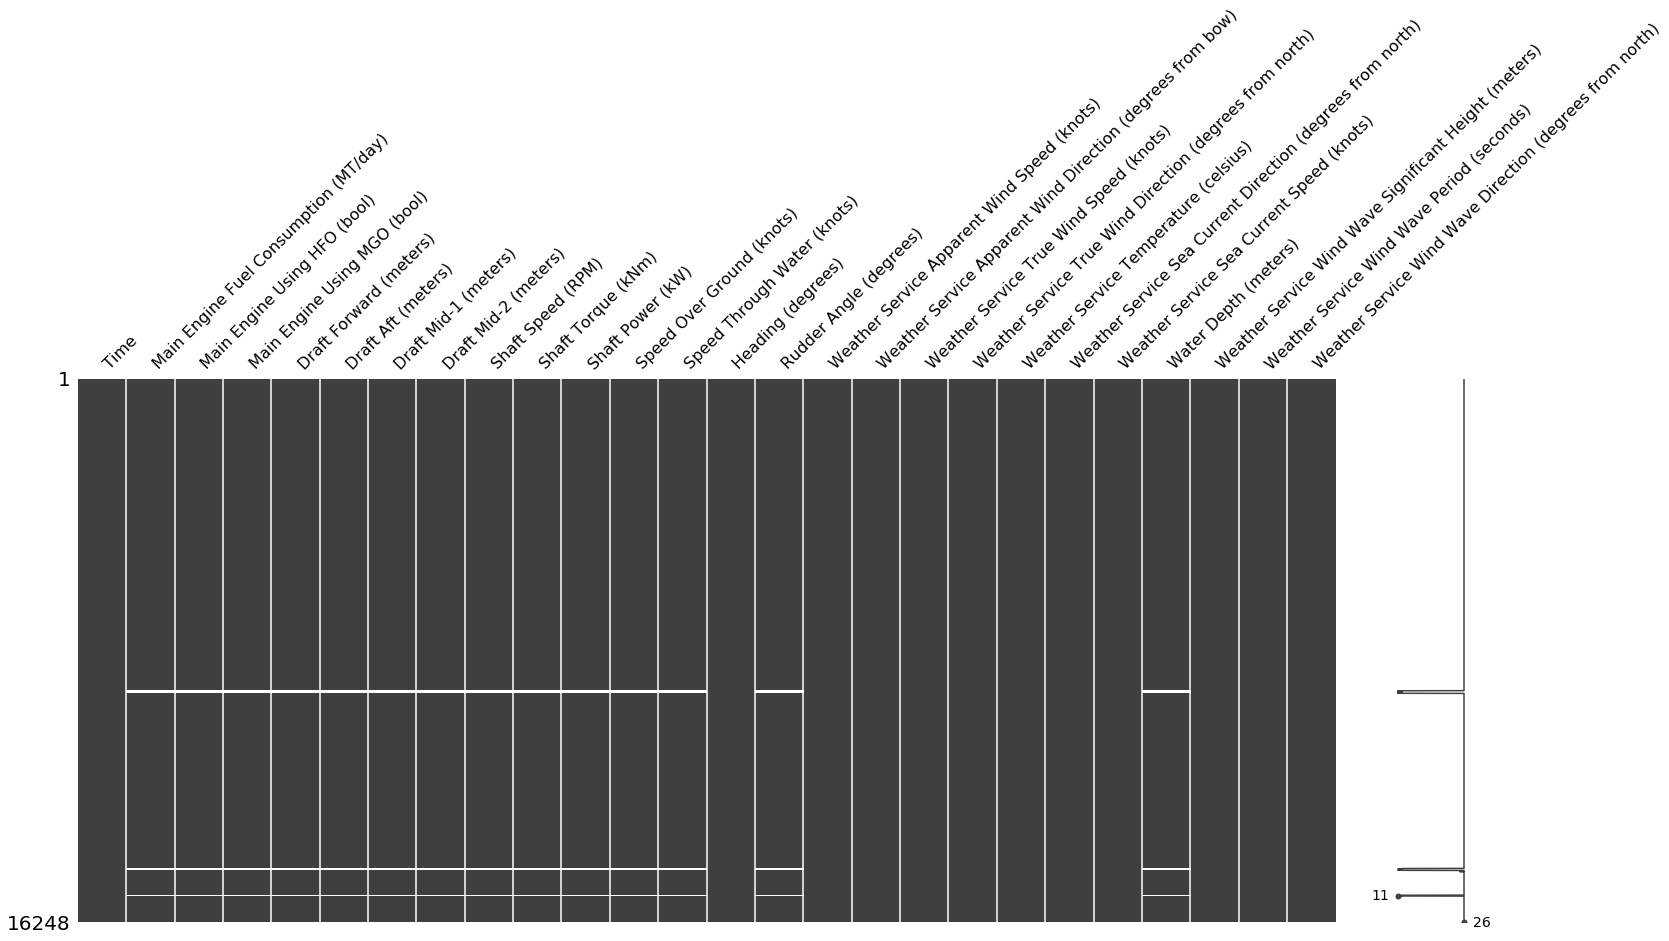

In [3]:
# Check missing values
print(df_raw.isnull().sum())
msno.matrix(df_raw)

1.0093549975381588


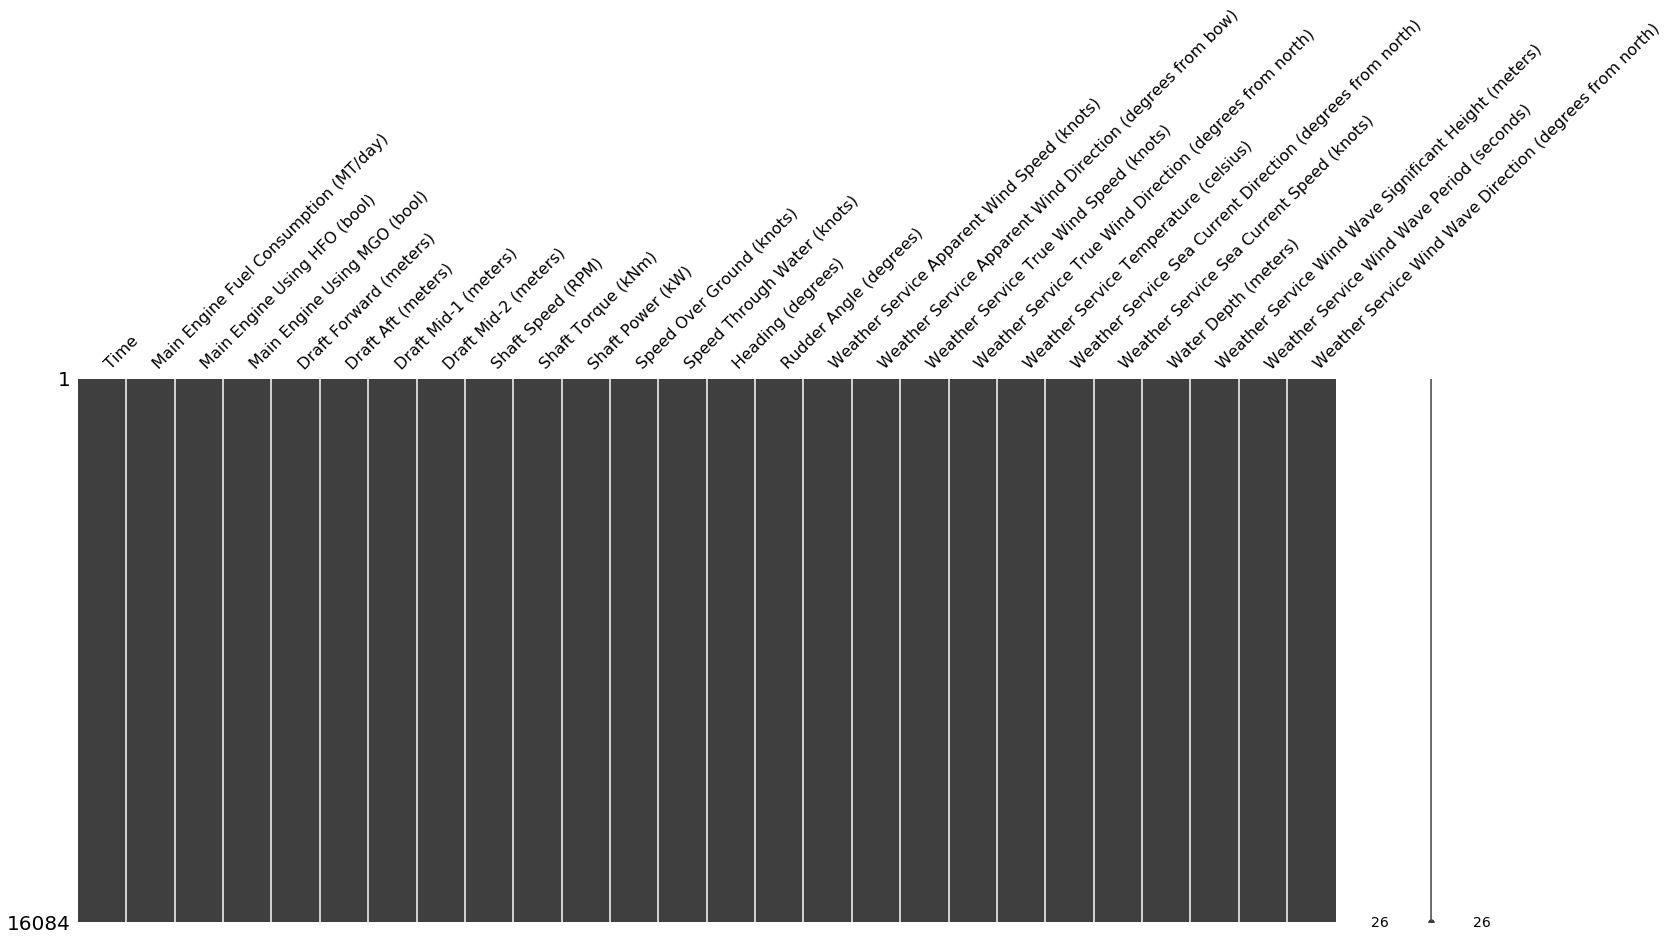

In [4]:
# Drop rows with missing target ~ 1% of records
df_mod = df_raw.copy().dropna()
print((1 - df_mod.shape[0] / n_records) * 100)
msno.matrix(df_mod)

### Column Sublists

In [5]:
# Create helper sublists of column names
cols_main  = df_mod.columns[0:4]
cols_draft = df_mod.columns[4:8]
cols_shaft = df_mod.columns[8:11]
cols_speed = df_mod.columns[11:15]
cols_wind  = df_mod.columns[15:19]
cols_sea   = df_mod.columns[19:23]
cols_wave  = df_mod.columns[23:26]
df_mod.shape

(16084, 26)

### Time and Main Engine

In [6]:
# Convert Unix time to datetime format
df_mod['Time'] = pd.to_datetime(df_mod['Time'], unit = 's')

# Show head
df_mod[cols_main].head()

,Time,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
0,2017-07-06 13:15:00,0.0,0.0,0.0
1,2017-07-06 14:00:00,0.0,0.0,0.0
2,2017-07-06 15:00:00,0.0,0.0,0.0
3,2017-07-06 16:00:00,0.0,0.0,0.0
4,2017-07-06 17:00:00,0.0,0.0,0.0


In [7]:
# Get descriptive statistics
df_mod[cols_main].describe()

,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
count,16084.000000,16084.000000,16084.000000
mean,17.182269,0.816453,0.174122
std,20.758227,0.386674,0.378717
min,-22.565517,0.000000,0.000000
25%,-0.048000,1.000000,0.000000
50%,15.922000,1.000000,0.000000
75%,39.785383,1.000000,0.000000
max,49.090823,1.000000,1.000000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a228e0a20>,
      dtype=object)

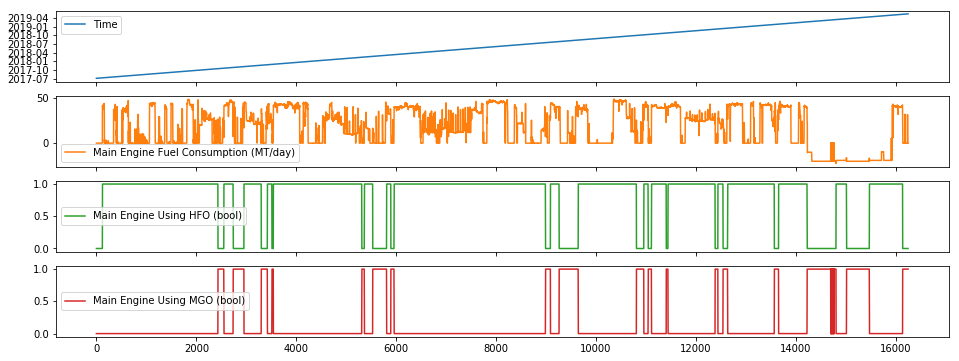

In [8]:
# Plot time series
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

-0.048000     2105
-20.193103     829
-19.200000     617
-0.050483      526
 0.000000      149
Name: Main Engine Fuel Consumption (MT/day), dtype: int64


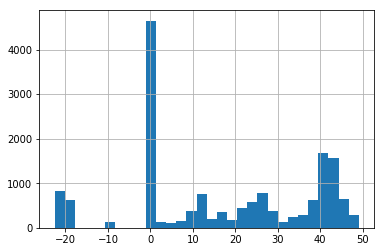

In [9]:
# Investigate negative fuel consumption
print(df_mod[cols_main[1]].value_counts().head())

# Plot frequency distribution of fuel consumption
df_mod[cols_main[1]].hist(bins=30)

In [10]:
# Assumption of failure of fuel consumption sensor (target variable) from 2/19/2019 - 5/1/2019
cutoff = -5
print(df_mod[df_mod[cols_main[1]] < cutoff].shape)
df_mod[df_mod[cols_main[1]] < cutoff][cols_main].head()

(1580, 26)


,Time,Main Engine Fuel Consumption (MT/day),Main Engine Using HFO (bool),Main Engine Using MGO (bool)
14232,2019-02-19 18:00:00,-10.649842,0.0,1.0
14233,2019-02-19 19:00:00,-10.121793,0.0,1.0
14234,2019-02-19 20:00:00,-10.577492,0.0,1.0
14235,2019-02-19 21:00:00,-10.121793,0.0,1.0
14236,2019-02-19 22:00:00,-10.121793,0.0,1.0


In [11]:
# Drop records with negative fuel consumption ~ 9.7% of records
print(df_mod[df_mod[cols_main[1]] < cutoff].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod[cols_main[1]] < cutoff].index)
df_mod.shape

9.724273756770065


(14504, 26)

In [12]:
# Calibrate fuel consumption with most frequent near-zero measurement (-0.048 MT/day)
zero_offset          = df_mod[cols_main[1]].value_counts().index[0]
df_mod[cols_main[1]] = df_mod[cols_main[1]] - zero_offset

# Set remaining negative fuel consumption values (all within ~0.12 MT/day) to zero
df_mod[cols_main[1]] = df_mod[cols_main[1]].clip(lower=0)
df_mod[cols_main[1]].value_counts().sort_index().head()

0.000000    3163
0.000017       1
0.000018       1
0.000021       1
0.000026       1
Name: Main Engine Fuel Consumption (MT/day), dtype: int64

In [13]:
# Revert HFO and MGO to booleans (unbalanced value counts)
print(df_mod[cols_main[2]].value_counts())
df_mod[cols_main[2]] = df_mod[cols_main[2]].astype('int64')
df_mod[cols_main[3]] = df_mod[cols_main[3]].astype('int64')

1.000000    12456
0.000000     2019
0.583333        4
0.083333        3
0.250000        3
0.666667        3
0.750000        2
0.083333        2
0.500000        2
0.166667        2
0.916667        1
0.833333        1
0.416667        1
0.833333        1
0.333333        1
0.583333        1
0.416667        1
0.333333        1
Name: Main Engine Using HFO (bool), dtype: int64


In [14]:
# Check that only one fuel gauge is indicated at a time 
df_mod['Fuel Gauge'] = df_mod[cols_main[2]] + df_mod[cols_main[3]]
print(df_mod['Fuel Gauge'].value_counts())

# Drop records with no HFO or MGO data ~ 1.1% of records
print(df_mod[df_mod['Fuel Gauge'] == 0].shape[0] / n_records * 100)
df_mod = df_mod.drop(df_mod[df_mod['Fuel Gauge'] == 0].index)
df_mod.shape

1    14323
0      181
Name: Fuel Gauge, dtype: int64
1.1139832594780896


(14323, 27)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a21866d68>,
      dtype=object)

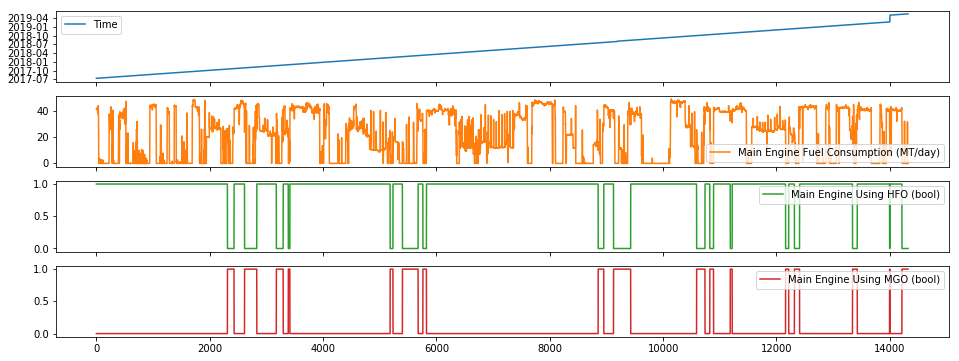

In [16]:
# Reset DataFrame index after dropping records
df_mod = df_mod.reset_index().drop('index',axis=1)

# Plot time series
fig_main, axes_main = plt.subplots(len(cols_main),1, figsize=(16,len(cols_main)*1.5), sharex=True)
df_mod[cols_main].plot(subplots=True, ax=axes_main)

In [46]:
# Explore fuel consumption by fuel source
df_hfo = df_mod[df_mod[cols_main[2]] == 1].copy()
df_hfo['Fuel'] = 'Main Engine Using HFO'

df_mgo = df_mod[df_mod[cols_main[3]] == 1].copy()
df_mgo['Fuel'] = 'Main Engine Using MGO'

# Drop records with zero fuel consumption (for EDA only)
df_fuel = pd.concat([df_hfo, df_mgo])
df_fuel = df_fuel[df_fuel[cols_main[1]] > 0]

df_fuel[[cols_main[1],'Fuel']].head()

,Main Engine Fuel Consumption (MT/day),Fuel
0,41.473078,Main Engine Using HFO
1,41.249985,Main Engine Using HFO
2,41.221734,Main Engine Using HFO
3,41.097703,Main Engine Using HFO
4,41.410789,Main Engine Using HFO


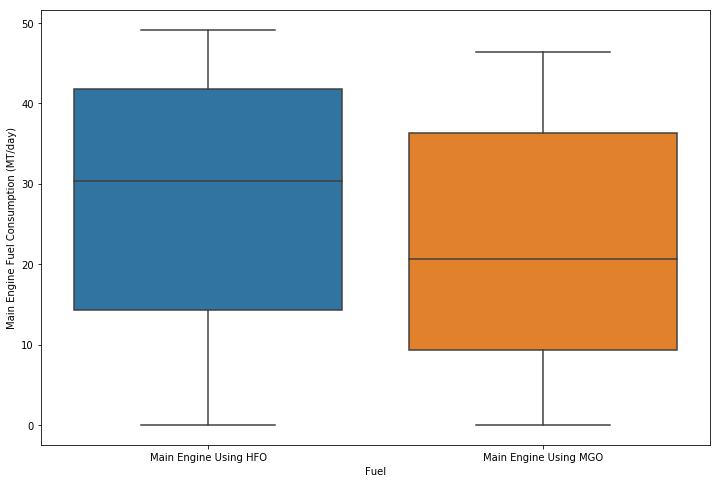

In [47]:
# Plot fuel consumption by fuel source
plt.figure('Fuel Source', figsize=(12,8))
sns.boxplot(x='Fuel', y=cols_main[1], data=df_fuel)

### Draft

In [18]:
# Show head
df_mod[cols_draft].head()

,Draft Forward (meters),Draft Aft (meters),Draft Mid-1 (meters),Draft Mid-2 (meters)
0,11.649717,11.799836,11.571744,11.474694
1,11.648145,11.787190,11.564664,11.485278
2,11.651354,11.790422,11.557041,11.495959
3,11.649094,11.803183,11.557006,11.497167
4,11.637952,11.795997,11.541174,11.510174


In [19]:
# Get descriptive statistics
df_mod[cols_draft].describe()

,Draft Forward (meters),Draft Aft (meters),Draft Mid-1 (meters),Draft Mid-2 (meters)
count,14323.000000,14323.000000,14323.000000,14323.000000
mean,8.021801,9.526998,8.776257,8.787778
std,2.537633,1.721995,2.097433,2.085132
min,1.761927,6.477834,5.264249,5.681231
25%,5.774130,7.934207,6.822983,6.843768
50%,7.266677,8.791292,8.082938,8.095812
75%,10.707531,11.501567,11.104153,11.128962
max,13.136587,12.589208,12.076237,12.127948


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a21d89a20>,
      dtype=object)

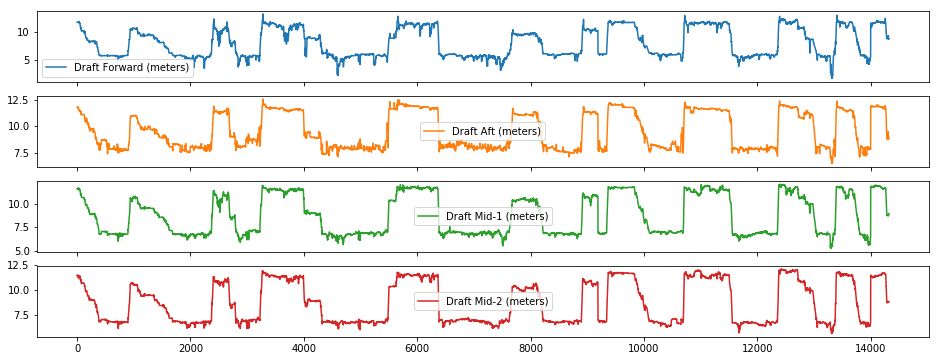

In [20]:
# Plot time series
fig_draft, axes_draft = plt.subplots(len(cols_draft),1, figsize=(16,len(cols_draft)*1.5), sharex=True)
df_mod[cols_draft].plot(subplots=True, ax=axes_draft)

### Shaft

In [21]:
# Show head
df_mod[cols_shaft].head()

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
0,85.903143,1040.493340,9335.364421
1,85.887671,1035.687927,9313.098930
2,85.908202,1035.380715,9307.803496
3,85.909091,1032.674218,9284.355848
4,85.890631,1040.666744,9356.266735


In [22]:
# Get descriptive statistics
df_mod[cols_shaft].describe()

,Shaft Speed (RPM),Shaft Torque (kNm),Shaft Power (kW)
count,14323.000000,14323.000000,14323.000000
mean,50.702632,576.352375,4798.063358
std,36.949748,449.515577,4087.344663
min,-7.110332,-0.001360,5.101946
25%,0.000000,7.254943,6.881096
50%,68.659683,703.353435,5094.836539
75%,85.522903,1031.434964,9227.204056
max,88.959431,1206.091541,11150.041983


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a25596198>,
      dtype=object)

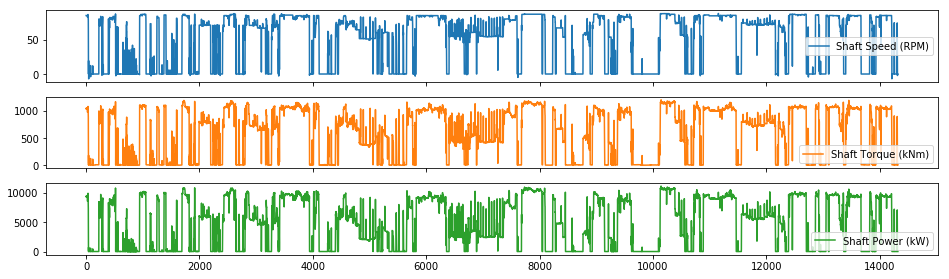

In [23]:
# Plot time series
fig_shaft, axes_shaft = plt.subplots(len(cols_shaft),1, figsize=(16,len(cols_shaft)*1.5), sharex=True)
df_mod[cols_shaft].plot(subplots=True, ax=axes_shaft)

### Speed and Heading

In [24]:
# Show head
df_mod[cols_speed].head()

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
0,15.927469,15.807160,99.148003,358.071607
1,15.448288,15.753783,86.778544,359.080607
2,15.388052,15.852655,86.329889,358.628799
3,15.399533,16.067271,87.081565,358.557335
4,15.518798,15.917059,85.922376,359.203618


In [25]:
# Get descriptive statistics
df_mod[cols_speed].describe()

,Speed Over Ground (knots),Speed Through Water (knots),Heading (degrees),Rudder Angle (degrees)
count,14323.000000,14323.000000,14323.000000,14323.000000
mean,9.313381,9.225522,187.010420,325.278952
std,6.620267,6.607825,101.759907,103.092620
min,0.000000,-0.812132,0.122061,0.000639
25%,0.422923,0.391188,89.996410,357.466173
50%,12.444654,12.537268,218.204847,358.598955
75%,15.173528,15.163896,276.744196,359.112534
max,19.844884,17.186902,359.824424,359.999195


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a22a75940>,
      dtype=object)

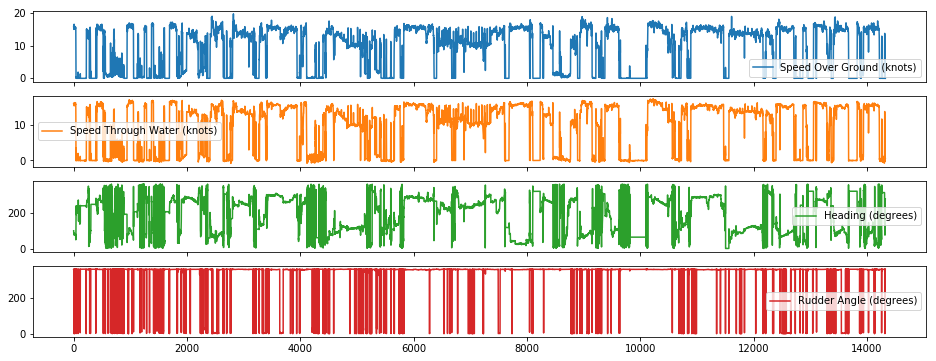

In [26]:
# Plot time series
fig_speed, axes_speed = plt.subplots(len(cols_speed),1, figsize=(16,len(cols_speed)*1.5), sharex=True)
df_mod[cols_speed].plot(subplots=True, ax=axes_speed)

### Wind

In [27]:
# Show head
df_mod[cols_wind].head()

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
0,10.406759,-3.418403,5.573875,285.539831
1,8.222903,-4.492690,7.279205,271.855120
2,6.574401,-18.524343,9.389550,279.183060
3,7.229827,-0.629331,8.170528,267.638437
4,8.626424,10.589120,7.215569,253.231194


In [28]:
# Get descriptive statistics
df_mod[cols_wind].describe()

,Weather Service Apparent Wind Speed (knots),Weather Service Apparent Wind Direction (degrees from bow),Weather Service True Wind Speed (knots),Weather Service True Wind Direction (degrees from north)
count,14323.000000,14323.000000,14323.000000,14323.000000
mean,14.552986,2.758093,11.761847,186.683569
std,8.586565,114.324019,6.393287,113.802871
min,0.000000,-358.561592,0.000000,0.000568
25%,7.829203,-41.550487,7.059986,77.786278
50%,13.128280,-1.683875,11.010876,194.647801
75%,20.143525,37.632356,15.657259,293.036899
max,51.955335,358.000339,40.845838,359.997076


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a260d1be0>,
      dtype=object)

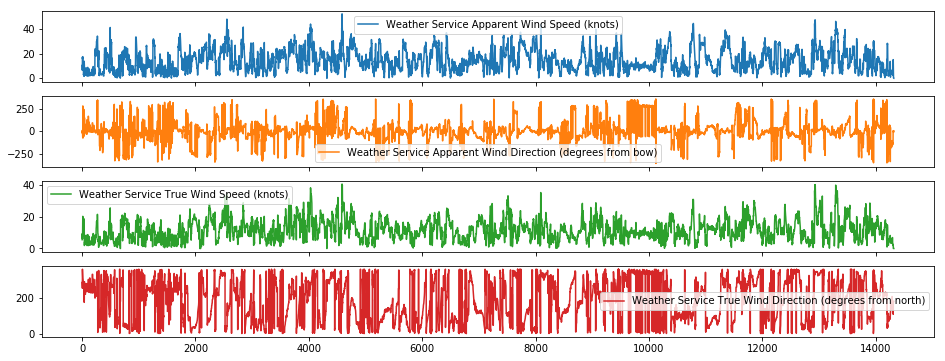

In [29]:
# Plot time series
fig_wind, axes_wind = plt.subplots(len(cols_wind),1, figsize=(16,len(cols_wind)*1.5), sharex=True)
df_mod[cols_wind].plot(subplots=True, ax=axes_wind)

### Sea

In [30]:
# Show head
df_mod[cols_sea].head()

,Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters)
0,25.161969,248.353210,0.237554,0.0
1,25.328048,248.870589,0.241738,0.0
2,25.932167,0.000000,0.000000,0.0
3,29.833849,0.000000,0.000000,0.0
4,30.717468,0.000000,0.000000,0.0


In [31]:
# Get descriptive statistics
df_mod[cols_sea].describe()

,Weather Service Temperature (celsius),Weather Service Sea Current Direction (degrees from north),Weather Service Sea Current Speed (knots),Water Depth (meters)
count,14323.000000,14323.000000,14323.000000,14323.000000
mean,21.975556,115.921057,0.270220,19.033429
std,12.316716,116.365410,0.406589,46.945757
min,-273.150000,0.000000,0.000000,0.000000
25%,18.024763,0.000000,0.000000,0.000000
50%,23.893554,83.580769,0.136563,0.000000
75%,27.089257,214.227918,0.354653,9.588156
max,52.559168,359.999716,3.184603,326.803230


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a27d6f588>,
      dtype=object)

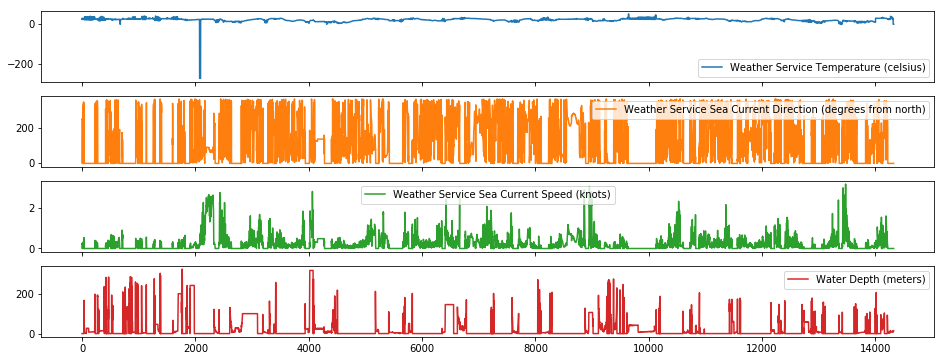

In [32]:
# Plot time series
fig_sea, axes_sea = plt.subplots(len(cols_sea),1, figsize=(16,len(cols_sea)*1.5), sharex=True)
df_mod[cols_sea].plot(subplots=True, ax=axes_sea)

### Wave

In [33]:
# Show head
df_mod[cols_wave].head()

,Weather Service Wind Wave Significant Height (meters),Weather Service Wind Wave Period (seconds),Weather Service Wind Wave Direction (degrees from north)
0,0.0,0.0,0.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0


In [34]:
# Get descriptive statistics
df_mod[cols_wave].describe()

,Weather Service Wind Wave Significant Height (meters),Weather Service Wind Wave Period (seconds),Weather Service Wind Wave Direction (degrees from north)
count,14323.000000,14323.000000,14323.000000
mean,0.312654,1.234230,33.059573
std,0.798160,2.761457,81.978310
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,6.323284,13.873590,356.882793


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a288c2748>,
      dtype=object)

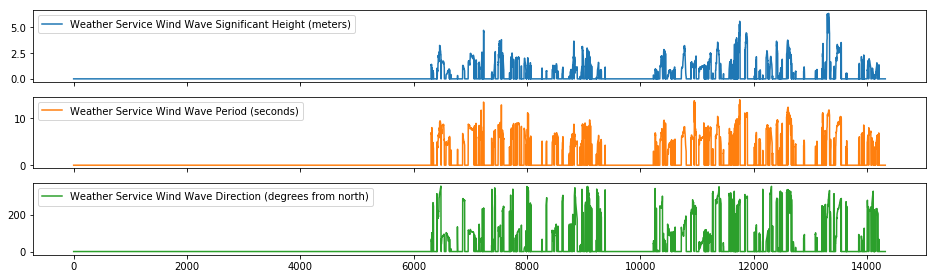

In [35]:
# Plot time series
fig_wave, axes_wave = plt.subplots(len(cols_wave),1, figsize=(16,len(cols_wave)*1.5), sharex=True)
df_mod[cols_wave].plot(subplots=True, ax=axes_wave)

# 1. Machine Learning Model

# 2. Speed Scores

# 3. Report

# 4. Sensor Drift